In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import random
import seaborn as sns
plt.style.use("fivethirtyeight")

from scipy.stats import chi2_contingency
from scipy.stats import chi2

C:\Users\ismiguzel\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Chi-Square Plot

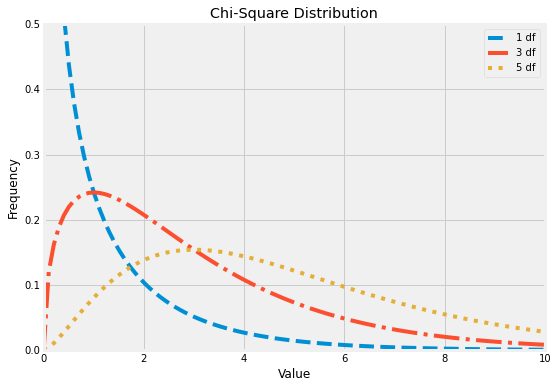

In [3]:
x=np.linspace(0,10,100)
fig, ax = plt.subplots(1,1, figsize=(8,6))
linestyles=['--','-.',':']
degrees_of_freedom=[1, 3, 5]
for df,ls in zip(degrees_of_freedom,linestyles):
    ax.plot(x, stats.chi2.pdf(x,df), linestyle=ls)
    ax.legend(['1 df', "3 df", "5 df"])
ax.set_title("Chi-Square Distribution")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
plt.xlim(0, 10)
plt.ylim(0, 0.5)
plt.show()

# Student's t-Distribution

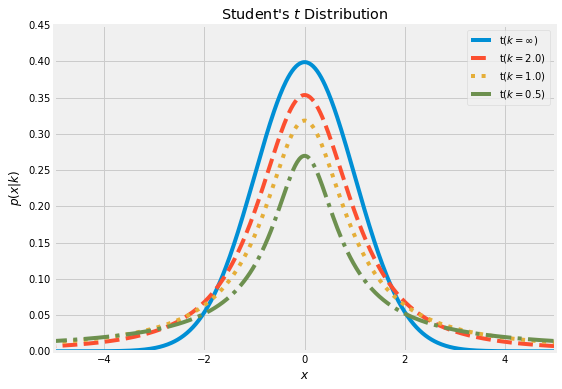

In [130]:
from scipy.stats import t as student_t

mu = 0
k_values = [1E10, 2, 1, 0.5]
linestyles = ['-', '--', ':', '-.']
x = np.linspace(-10, 10, 1000)

# plot the distributions
fig, ax = plt.subplots(figsize=(8, 6))

for k, ls in zip(k_values, linestyles):
    dist = student_t(k, 0)

    if k >= 1E10:
        label = r'$\mathrm{t}(k=\infty)$'
    else:
        label = r'$\mathrm{t}(k=%.1f)$' % k

    plt.plot(x, dist.pdf(x), ls=ls, label=label)

plt.xlim(-5, 5)
plt.ylim(0.0, 0.45)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|k)$')
plt.title("Student's $t$ Distribution")

plt.legend()
plt.savefig("t_distribution")
plt.show()

# Example 1: Solution with Chi-Square Test

In [10]:
df_ex = {"Outcome": ["Conversion", "No Conversion"], 
         "Initial Layout": [150, 23567],
         "New Layout": [162, 23230]}

df_ex = pd.DataFrame(df_ex)

In [11]:
df_ex

,Outcome,Initial Layout,New Layout
0,Conversion,150,165
1,No Conversion,23567,23230


In [13]:
cr_a = 150/23717
print(cr_a)
cr_b = 165/23395
print(cr_b)
#Relative uplift in conversion rate = (cr_b - cr_a)/cr_a
rel_uplift = (cr_b - cr_a)/cr_a
print(rel_uplift)

0.006324577307416621
0.006925444596443228
0.09500512995896025


In [18]:
# contingency table
print(table)
stat, p, dof, expected = stats.chi2_contingency(table)
alpha = 0.05

# interpret p-value
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Reject null hypothesis)')
else:
    print('Do not reject null hypothesis')
    
# interpret test-statistic
prob = 1 - alpha
critical = stats.chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Reject null hypothesis)')
else:
    print('Do not reject null hypothesis')

[[  150 23717]
 [  165 23395]]
significance=0.050, p=0.365
Do not reject null hypothesis
probability=0.950, critical=3.841, stat=0.822
Do not reject null hypothesis


# Example 1: Solution with Permutation Test

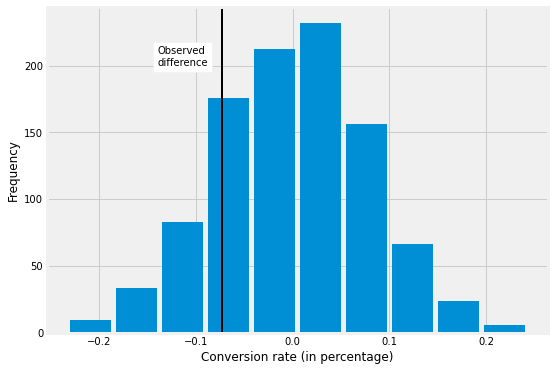

In [67]:
obs_pct_diff = 100 * (150 / 23717 - 165 / 23395)
conversion = [0] * 46797
conversion.extend([1] * 315)
conversion = pd.Series(conversion)

def perm_func(x, nA, nB):
    n = nA + nB
    id_B = set(random.sample(range(n), nB))
    id_A = set(range(n)) - id_B
    return x.loc[idx_B].mean() - x.loc[id_A].mean()

perm_diffs = [100 * perm_fun(conversion, 23717, 23395)
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(perm_diffs, rwidth=0.9)
ax.axvline(x=obs_pct_diff, lw=2, color="black")
ax.text(-0.14, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (in percentage)')
ax.set_ylabel('Frequency')
plt.savefig("Permutation_test_plot")
plt.show()

In [68]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.823


# Example 2: Solution with t-Test

In [71]:
data = pd.read_csv("./data_Sample.csv", sep=";")
data["Time"] = data["Time"]*100

In [72]:
data.head()

,Page,Time
0,Old design,35.0
1,New design,120.0
2,Old design,80.0
3,New design,120.0
4,Old design,150.0


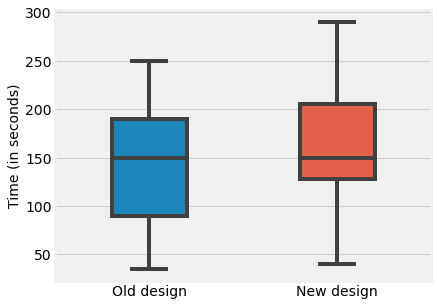

In [123]:
data["Page"] = data["Page"].apply(lambda x: str(x))
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.boxplot(x=data["Page"], y=data["Time"], width=0.4)
ax.set_ylabel('Time (in seconds)', size=14)
ax.set_xlabel("")
ax.tick_params(labelsize=14)
plt.savefig('avg_time_spend.png')
plt.show()

In [121]:
mean_cont = np.mean(data[data["Page"] == "Old design"]["Time"])
mean_exp = np.mean(data[data["Page"] == "New design"]["Time"])
mean_diff = mean_exp - mean_cont
print(f"Average difference between experiment and control samples: {mean_diff}")

Average difference between experiment and control samples: 22.857142857142833


In [137]:
test_res = stats.ttest_ind(data[data.Page ==  "Old design"]["Time"], 
                      data[data.Page == "New design"]["Time"],
                      equal_var=False)
print(f'p-value for single sided test: {test_res.pvalue / 2:.4f}')
if test_res.pvalue <= alpha:
    print('Reject null hypothesis)')
else:
    print('Do not reject null hypothesis')

p-value for single sided test: 0.1020
Do not reject null hypothesis


# Example 2: Solution with permutation test

0.102


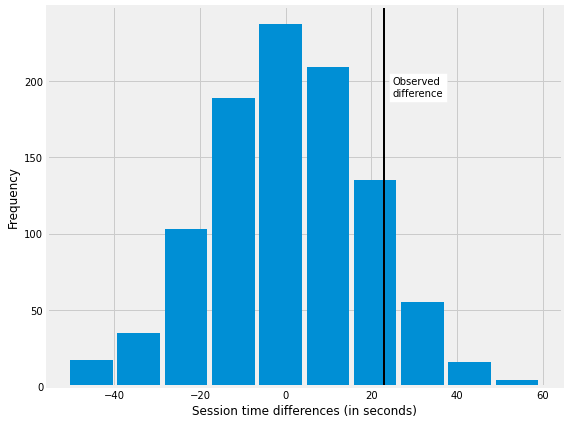

In [149]:
nA = data[data.Page == 'Old design'].shape[0]
nB = data[data.Page == 'New design'].shape[0]

perm_diffs = [perm_fun(data.Time, nA, nB) for _ in range(1000)]

larger=[i for i in perm_diffs if i > mean_exp-mean_cont]
print(len(larger)/len(perm_diffs))

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(perm_diffs, rwidth=0.9)
ax.axvline(x = mean_exp - mean_cont, color='black', lw=2)
ax.text(25, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')
plt.savefig("Permutation_test_plot2")
plt.tight_layout()
plt.show()